# Compute ImageNet Calibration Metrics

In [714]:
import blackhc.project.script

In [715]:
from dataclasses import dataclass

import numpy as np
import torch

In [716]:
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

In [717]:
@dataclass
class EnsembleLogitEvaluation:
    # BxNxC
    ensemble_logits: torch.Tensor
    # B
    labels: torch.Tensor

In [718]:
dataset_name = "cinic10_test"
# dataset_name = "cifar10_test"
# dataset_name = "pacs_cartoon_sketch"
# dataset_name = "pacs_cartoon_sketch_resnet152d"
# dataset_name = "pacs_cartoon_sketch_beit_large_patch16_224"
# dataset_name = "pacs_cartoon_sketch_vit_base_patch16_384"

# architecture="resnet152d"
# architecture="beit_large_patch16_224"
# architecture="convnext_large_in22ft1k"
# architecture="vit_base_patch16_384"

# dataset_name = "pacs_cartoon_sketch_beit_large_patch16_224"
val_probs_labels = !ls compute_results/{dataset_name}*_ensemble_probs*.pt
val_probs_labels

['compute_results/cinic10_test_ensemble_probs_labels_ddu_wrn.pt']

In [719]:
def load_ensemble_probs_N_K_C(model_paths):
    probs = []
    labels = None
    for model_path in model_paths:
        prediction_info = torch.load(model_path)
        print("Loading:", prediction_info["pretrained_cfg"])
        new_labels = prediction_info["labels"]
        if labels is not None:
            assert torch.all(labels == new_labels)
        else:
            labels = new_labels
        probs += [prediction_info["predictions"]]
    probs = torch.cat(probs, dim=1)
    print("Loaded shape:", probs.shape)
    return probs, labels

In [720]:
ensemble_probs, dataset_labels = load_ensemble_probs_N_K_C(val_probs_labels)

Loading: DDU WideResNet Models
Loaded shape: torch.Size([90000, 25, 10])


In [721]:
import scipy.stats
from scipy.optimize import minimize_scalar
from scipy.special import digamma, polygamma

In [722]:
def entropy(probs):
    """Compute the prediction entropy for each ensemble member separately."""
    nats = probs * torch.log(probs)
    nats[nats.isnan()] = 0.0
    return -nats.sum(dim=-1)

In [723]:
def ensemble_entropy(probs):
    """Compute the ensemble prediction entropy."""
    mean_probs = probs.mean(dim=1, keepdim=False)

    nats = mean_probs * mean_probs.log()
    nats[nats.isnan()] = 0.0
    entropy = -nats.sum(dim=-1)

    return entropy

In [724]:
def info_gain(probs):
    p_entropy = ensemble_entropy(probs)

    avg_softmax_entropies = entropy(probs).mean(dim=1, keepdim=False)

    value = p_entropy - avg_softmax_entropies
    return value

In [725]:
def probs_confidence_predictions(ensemble_probs):
    N, K, C = ensemble_probs.shape
    mean_probs = ensemble_probs.mean(dim=1, keepdim=False)

    confidences, predictions = torch.max(mean_probs, dim=-1)
    assert mean_probs.shape == (N, C)
    assert confidences.shape == (N,)
    assert predictions.shape == (N,)
    return mean_probs.numpy(), confidences.numpy(), predictions.numpy()

In [726]:
mean_probs, mean_confidences, mean_predictions = probs_confidence_predictions(ensemble_probs)

In [727]:
def top1_probs_confidence_predictions(ensemble_probs):
    N, K, C = ensemble_probs.shape
    one_hot_probs = torch.nn.functional.one_hot(torch.argmax(ensemble_probs, dim=-1), num_classes=C).float()
    mean_probs = one_hot_probs.mean(dim=1, keepdim=False)

    confidences, predictions = torch.max(mean_probs, dim=-1)
    assert mean_probs.shape == (N, C)
    assert confidences.shape == (N,)
    assert predictions.shape == (N,)
    return mean_probs.numpy(), confidences.numpy(), predictions.numpy()

In [728]:
top_probs, top_confidences, top_predictions = top1_probs_confidence_predictions(ensemble_probs)

# Compare Top1 and Normal Predictions and Probabilities

In [729]:
# How many predictions are different? Hopefully none?

(mean_predictions != top_predictions).sum() / len(mean_predictions)

# So about 2% :o

0.010477777777777779

In [730]:
print((mean_predictions == dataset_labels.numpy()).mean())
print((top_predictions == dataset_labels.numpy()).mean())

0.7871333333333334
0.7864222222222222


So the overall ensemble is about 0.003% better than using one-hot predictions! Which means the predictions between top and normal mostly disagree when they are wrong.

### Spike: Check that `torch.gather` and `np.take_along_axis` behave as expected

In [731]:
all(
    torch.gather(torch.as_tensor(top_probs), dim=1, index=dataset_labels.unsqueeze(1)).squeeze(1).numpy()
    == top_probs[range(len(dataset_labels)), dataset_labels.numpy()]
)

True

In [732]:
all(
    top_probs[range(len(dataset_labels)), dataset_labels.numpy()]
    == np.take_along_axis(top_probs, dataset_labels.numpy()[..., None], axis=-1).squeeze(-1)
)

True

# Compute Disagreement and Accuracy

In [733]:
def get_predicted_accuracy(probs):
    # E p(Y^ | x) = \sum p(Y^=c | x)^2
    N, C = probs.shape
    predicted_accuracy = (probs ** 2).sum(axis=-1)
    assert predicted_accuracy.shape == (N,)
    return predicted_accuracy


def get_predicted_error(probs):
    return 1 - get_predicted_accuracy(probs)


# TODO: remove these symbols?
get_agreement_rate = get_predicted_accuracy
get_disagreement_rate = get_predicted_error

In [734]:
def get_true_predicted_probs(probs, labels):
    N, C = probs.shape
    assert labels.shape == (N,)
    true_predicted_probs = np.take_along_axis(probs, labels[..., None], axis=1).squeeze(1)
    assert true_predicted_probs.shape == (N,)
    return true_predicted_probs


# This is the expected accuracy, not the top1 accuracy!
get_accuracy = get_true_predicted_probs

# This is the expected error, not the top1 error!
def get_error(probs, labels):
    return 1 - get_accuracy(probs, labels)

In [735]:
get_true_predicted_probs(mean_probs, dataset_labels.numpy())

array([0.9993647 , 0.4101941 , 0.9994998 , ..., 0.97904617, 0.99933124,
       0.99830604], dtype=float32)

In [736]:
def get_top1_accuracy(probs, labels):
    return 1.0 * (probs.argmax(axis=-1) == labels)


def get_top1_error(probs, labels):
    return 1.0 - get_top1_accuracy(probs, labels)


def get_top1_predicted_error(probs):
    return 1.0 - probs.max(axis=-1)

In [737]:
get_top1_error(mean_probs, dataset_labels.numpy()).mean()

0.21286666666666668

In [738]:
get_top1_predicted_error(mean_probs).mean()

0.10923288

# Compute Calibrations

In [739]:
labels = dataset_labels.numpy()

In [740]:
get_accuracy(mean_probs, labels).mean(), get_accuracy(top_probs, labels).mean()

(0.76384026, 0.77154046)

In [741]:
# from ddu_redux


def get_ece(predictions: np.ndarray, confidences: np.ndarray, labels: np.ndarray, *, num_bins: int):
    assert len(confidences) == len(predictions) == len(labels)

    accuracy = 1 * (predictions == labels)
    # print(accuracy.sum() / len(accuracy))

    bin_edges = np.histogram_bin_edges(confidences, bins=num_bins, range=[0, 1])
    bin_indices = np.digitize(confidences, bin_edges[:-1], right=False) - 1
    # print(bin_edges)
    # plt.hist(bin_indices, bins=num_bins)
    # plt.show()

    calibration_total_error = 0

    for bin_index in range(num_bins):
        bin_total_accuracy = np.sum(accuracy[bin_indices == bin_index])
        bin_total_confidence = np.sum(confidences[bin_indices == bin_index])
        # print(bin_total_accuracy, bin_total_confidence, sum(bin_indices == bin_index))

        calibration_total_error += np.abs(bin_total_accuracy - bin_total_confidence)

    calibration_error = calibration_total_error / len(labels)

    return calibration_error

In [742]:
get_ece(top_predictions, top_confidences, labels, num_bins=10), get_ece(
    mean_predictions, mean_confidences, labels, num_bins=10
)

(0.1241057896508111, 0.10363377193212508)

In [743]:
def get_cace_jiang_paper(probs: np.ndarray, labels: np.ndarray, *, num_bins: int):
    # Following the appendix
    N, C = probs.shape
    assert labels.shape == (N,)

    bin_edges = np.histogram_bin_edges(probs, bins=num_bins, range=(0, 1))
    bin_indices = np.stack(
        [np.digitize(probs[:, label], bin_edges[:-1], right=False) - 1 for label in range(C)], axis=-1
    )

    cace = 0
    for bin_index in range(num_bins):
        weights = (bin_indices == bin_index).sum() / N
        if not weights:
            continue
        q = probs[bin_indices == bin_index].mean()
        numerator_weights = (
            sum(np.logical_and(bin_indices[:, label] == bin_index, labels == label) for label in range(C)).sum() / N
        )
        cace += np.abs(numerator_weights / weights - q) * weights

    return cace

In [744]:
get_cace_jiang_paper(top_probs, labels, num_bins=10), get_cace_jiang_paper(mean_probs, labels, num_bins=10)

(0.25864444386615265, 0.21472291909868108)

In [745]:
def get_multi_ece(probs: np.ndarray, labels: np.ndarray, *, num_bins: int):
    N, C = probs.shape
    assert len(probs) == len(labels)

    mece = 0

    predictions = np.argmax(probs, axis=-1)

    for y in range(C):
        y_probs = probs[:, y]
        bin_edges = np.histogram_bin_edges(y_probs, bins=num_bins, range=[0, 1])
        bin_indices = np.digitize(y_probs, bin_edges[:-1], right=False) - 1

        for bin_index in range(num_bins):
            bin_mask = bin_indices == bin_index
            bin_accuracy = np.sum(y == labels[bin_mask])
            bin_confidence = np.sum(y_probs[bin_mask])

            mece += np.abs(bin_accuracy - bin_confidence)

    mece /= N

    return mece

In [746]:
import pandas as pd

In [747]:
def get_rejection_plot_rows(*, rejection_scores, max_score, num_bins, probs, labels):
    #rejection_scores = rejection_scores.round(decimals=2)
    confidences, predictions = torch.max(torch.as_tensor(probs), dim=-1)
    confidences = confidences.numpy()
    predictions = predictions.numpy()

    if max_score is None:
        max_score = rejection_scores.max()

    rows = []
    last_threshold = None
    last_indices = None
    for i, threshold in enumerate(np.linspace(0., max_score, num=num_bins, endpoint=True)):
        if i < num_bins - 1:
            indices = rejection_scores <= threshold
        else:
            indices = rejection_scores <= rejection_scores.max() * 2
        # if last_threshold:
        #   indices = np.logical_and(indices, rejection_scores > last_threshold)
        # if not sum(indices):
        #   print(last_threshold, threshold, sum(indices))
        #   continue
        # last_threshold = threshold

        print(threshold, sum(indices))

        indices = np.nonzero(indices)[0]
        # indices = np.random.choice(indices, size=7500)

        # if last_indices is not None:
        #   indices = np.concatenate([indices, last_indices])
        # last_indices = indices

        num_elements = len(indices)

        if not num_elements:
            continue

        mean_rejection_score = rejection_scores[indices].mean()
        max_rejection_score = rejection_scores[indices].max()

        bin_probs = probs[indices]
        bin_labels = labels[indices]

        predicted_error = get_predicted_error(bin_probs).mean()
        error = get_error(bin_probs, bin_labels).mean()
        calibration = np.abs(error - predicted_error)
        
        top1_predicted_error = get_top1_predicted_error(bin_probs).mean()
        top1_error = get_top1_error(bin_probs, bin_labels).mean()
        top1_calibration = np.abs(top1_error - top1_predicted_error)
        
        ece = get_ece(predictions[indices], confidences[indices], bin_labels, num_bins=10)
        mece = get_multi_ece(bin_probs, bin_labels, num_bins=10)
        cace = get_cace_jiang_paper(bin_probs, bin_labels, num_bins=10)

        rows.append(
            dict(
                num_elements=num_elements,
                mean_rejection_score=mean_rejection_score,
                max_rejection_score=max_rejection_score,
                ece=ece,
                cace=cace,
                mece=mece,
                calibration=calibration,
                error=error,
                predicted_error=predicted_error,
                top1_calibration=top1_calibration,
                top1_error=top1_error,
                top1_predicted_error=top1_predicted_error
            )
        )

    return rows

In [748]:
import seaborn as sns

In [749]:
get_disagreement_rate(mean_probs).max()

0.869123

In [750]:
if dataset_name == "cinic10_test":
    disrate_kwargs = dict(max_score=0.8, num_bins=16)
    infogain_kwargs = dict(max_score=0.7, num_bins=16)
elif dataset_name == "cifar10_test":
    disrate_kwargs = dict(max_score=0.65, num_bins=5)
    infogain_kwargs = dict(max_score=0.6, num_bins=5)
elif dataset_name == "pacs_cartoon_sketch_vit_base_patch16_384":
    disrate_kwargs = dict(max_score=0.8, num_bins=8)
    infogain_kwargs = dict(max_score=0.4, num_bins=8)
elif dataset_name == "pacs_cartoon_sketch_beit_large_patch16_224":
    disrate_kwargs = dict(max_score=0.7, num_bins=8)
    infogain_kwargs = dict(max_score=0.2, num_bins=8)
elif dataset_name == "pacs_cartoon_sketch_resnet152d":
    disrate_kwargs = dict(max_score=None, num_bins=8)
    infogain_kwargs = dict(max_score=0.02, num_bins=8)
elif dataset_name == "pacs_cartoon_sketch":
    disrate_kwargs = dict(max_score=None, num_bins=8)
    infogain_kwargs = dict(max_score=0.8, num_bins=8)
else:
    raise ValueError(f"Unknown dataset {dataset_name}!")

In [751]:
info_gain(ensemble_probs).numpy().max(), dataset_name

(1.0159197, 'cinic10_test')

0.0 0
0.2 64355
0.4 72591
0.6000000000000001 83490
0.8 90000


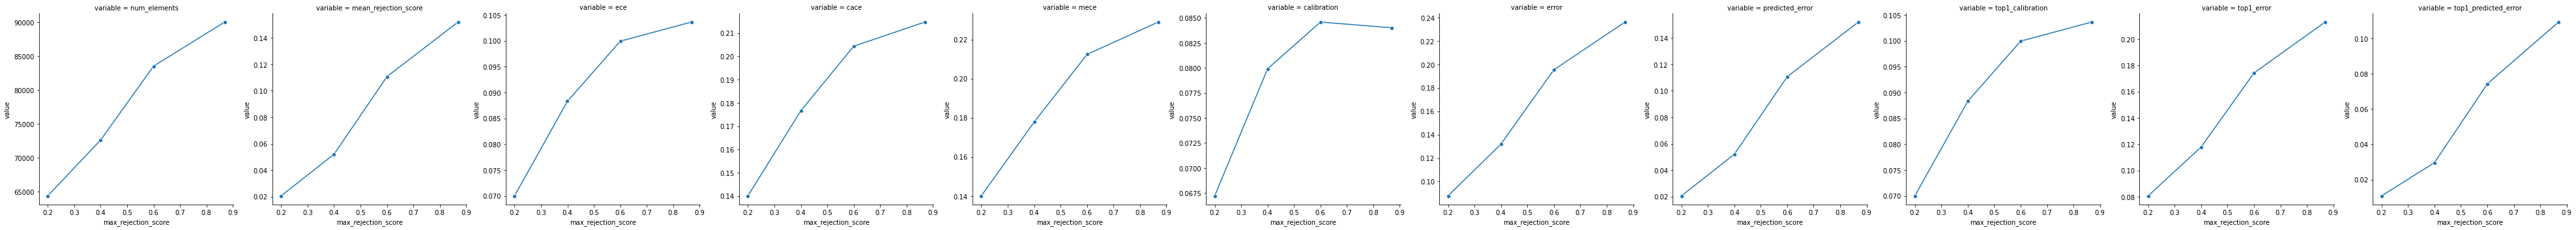

In [752]:
rows = get_rejection_plot_rows(
    rejection_scores=get_disagreement_rate(mean_probs), **disrate_kwargs, probs=mean_probs, labels=labels
)

df = pd.DataFrame.from_dict(rows)
df.drop_duplicates(inplace=True)

dfm = pd.melt(df, id_vars="max_rejection_score")

sns.relplot(
    data=dfm,
    x="max_rejection_score",
    y="value",
    col="variable",
    marker="o",
    kind="line",
    aspect=1,
    facet_kws=dict(sharey=False),
)

df.to_csv(f"{dataset_name}_mean_disrate.csv", index=False)

0.0 0
0.175 63841
0.35 75040
0.5249999999999999 86178
0.7 90000


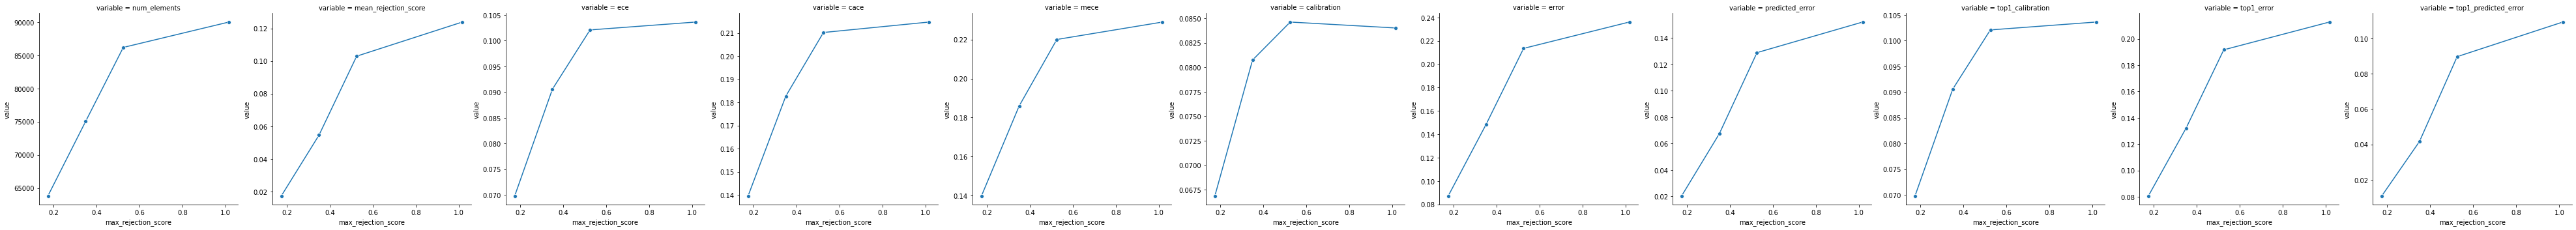

In [753]:
rows = get_rejection_plot_rows(
    rejection_scores=info_gain(ensemble_probs.double()).numpy(), **infogain_kwargs, probs=mean_probs, labels=labels
)

df = pd.DataFrame.from_dict(rows)
df.drop_duplicates(inplace=True)

df.to_csv(f"{dataset_name}_mean_infogain.csv", index=False)

dfm = pd.melt(df, id_vars="max_rejection_score")

sns.relplot(
    data=dfm,
    x="max_rejection_score",
    y="value",
    col="variable",
    marker="o",
    kind="line",
    aspect=1,
    facet_kws=dict(sharey=False),
)

0.0 0
0.2 64355
0.4 72591
0.6000000000000001 83490
0.8 90000


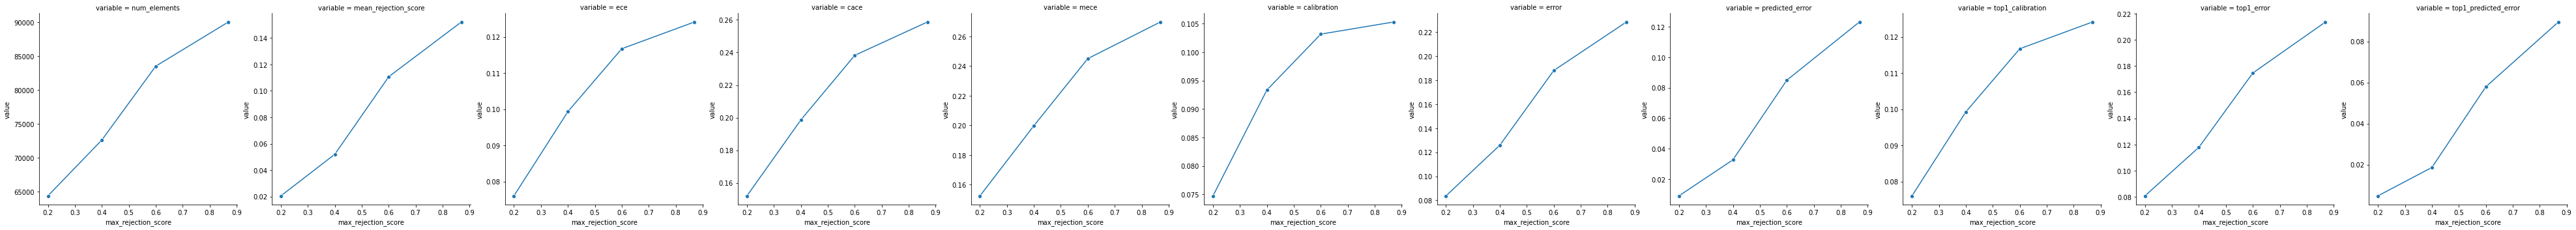

In [754]:
rows = get_rejection_plot_rows(
    rejection_scores=get_disagreement_rate(mean_probs), **disrate_kwargs, probs=top_probs, labels=labels
)

df = pd.DataFrame.from_dict(rows)
df.drop_duplicates(inplace=True)

dfm = pd.melt(df, id_vars="max_rejection_score")

sns.relplot(
    data=dfm,
    x="max_rejection_score",
    y="value",
    col="variable",
    marker="o",
    kind="line",
    aspect=1,
    facet_kws=dict(sharey=False),
)

df.to_csv(f"{dataset_name}_top_disrate.csv", index=False)

0.0 0
0.175 63841
0.35 75040
0.5249999999999999 86178
0.7 90000


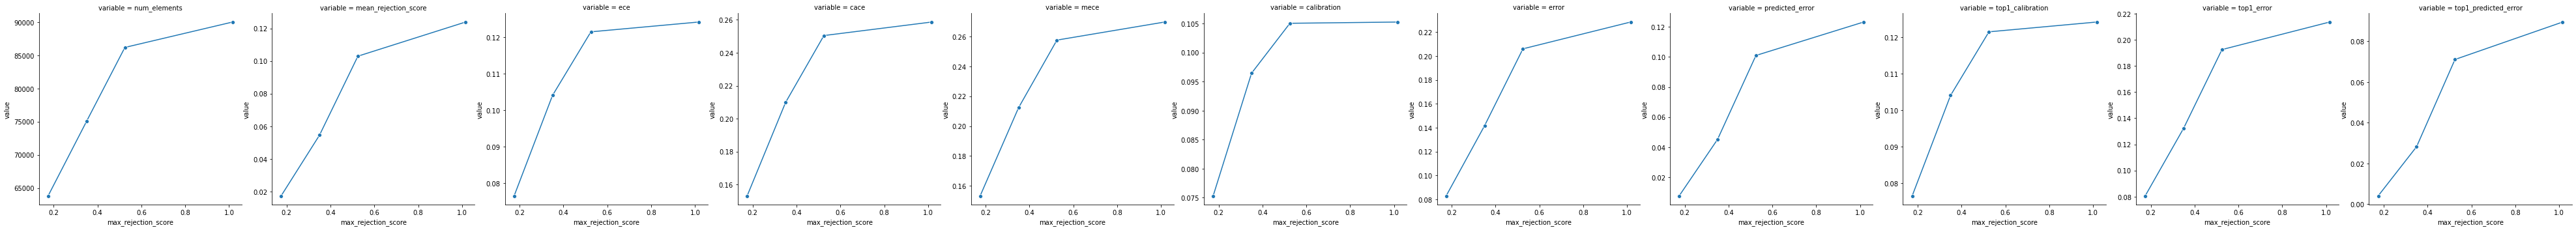

In [755]:
rows = get_rejection_plot_rows(
    rejection_scores=info_gain(ensemble_probs).numpy(), **infogain_kwargs, probs=top_probs, labels=labels
)

df = pd.DataFrame.from_dict(rows)
df.drop_duplicates(inplace=True)

df.to_csv(f"{dataset_name}_top_infogain.csv", index=False)

dfm = pd.melt(df, id_vars="max_rejection_score")

sns.relplot(
    data=dfm,
    x="max_rejection_score",
    y="value",
    col="variable",
    marker="o",
    kind="line",
    aspect=1,
    facet_kws=dict(sharey=False),
)